In [1]:
import os

%load_ext autoreload
%autoreload 2

%cd ..
project_path = os.path.abspath('')

!hostname

/mnt/localdata/datasets/vervet1818/vervet1818-3d
medpc177


In [2]:
import sys, os

import h5py as h5
import numpy as np
import SimpleITK as sitk

import imageio
import matplotlib.pyplot as plt

import pli
import pli.image as im

# Add code
sys.path.insert(0, os.path.join(project_path, "code"))

import utils
import registration as reg

In [3]:
# blockface_path = "/mnt/localdata/pli/vervet1818/blockface/tomedian_closecropped/Vervet1818_PLI_F810C_s1051.png"
# mask_path = "in/vervet1818-stitched/data/mask/pliunet-v3/Vervet1818a_60mu_70ms_s1051_x00-15_y00-13_Mask.h5"

bf_path = "/mnt/localdata/pli/vervet1818/blockface/tomedian_closecropped/Vervet1818_PLI_F810C_s0824.png"
mask_path = "/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818/vervet1818-stitched/data/mask/pliunet-v3/Vervet1818abc_60mu_70ms_s0824_x00-27_y00-35_Mask.h5"
ntrans_path = "/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818/vervet1818-stitched/data/STITCHED/Vervet1818abc_60mu_70ms_s0824_x00-27_y00-35_NTransmittance.h5"

Mask mu 20.8
Segment 0, (2925, 2303)


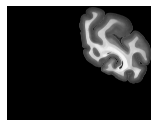

Segment 1, (2925, 2303)


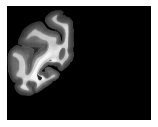

Segment 2, (2925, 2303)


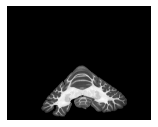

In [4]:
# Load cortex mask and define spacing

pyramid = 4
min_size = 1e5
mask_mu = (2 ** 4) * 1.3

###

mask = utils.load_h5(mask_path, f'pyramid/{pyramid:02d}')
ntrans = utils.load_h5(ntrans_path, f'pyramid/{pyramid:02d}')
mask_bin = mask < 3
mask_segments, ntrans_segments = utils.get_mask_segments(mask_bin, mask_mu, ntrans, min_size)

print("Mask mu", mask_mu)
for i, ts in enumerate(ntrans_segments):
    print(f"Segment {i}, {ts.GetSize()}")
    im.show(sitk.GetArrayViewFromImage(ts), size=2)

Generate segments k=2
Downsize blockface to shape (256, 238)
Create graph with beta 1 and eps 1e-06
Perform spectral clustering
Generate segments k=3
Downsize blockface to shape (256, 238)
Create graph with beta 1 and eps 1e-06
Perform spectral clustering
BF mu 66.084
Segment 0, (846, 909)


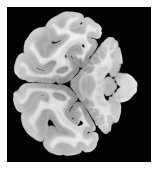

Segment 1, (846, 909)


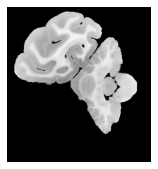

Segment 2, (846, 909)


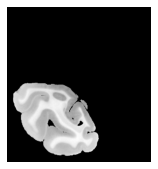

Segment 3, (846, 909)


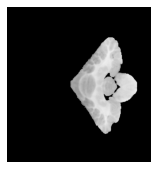

Segment 4, (846, 909)


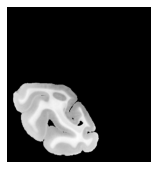

Segment 5, (846, 909)


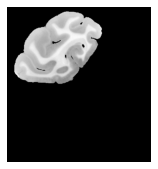

In [5]:
# Load blockface and define spacing

bf_mu = 66.084
min_size = 1e4

k_max = 3
px = 256 # 256

###

bf = np.array(imageio.imread(bf_path))
bf_gray = np.mean(bf, axis=-1)
bf_mask = bf_gray > 0
bf_mask_segments, bf_segments = utils.get_bf_segments(bf_gray, bf_mu, k_max, px)

print("BF mu", bf_mu)
for i, bs in enumerate(bf_segments):
    print(f"Segment {i}, {bs.GetSize()}")
    im.show(sitk.GetArrayViewFromImage(bs), size=2)

In [6]:
n_samples = 180
n_iterations = 512
lr = 1.0
allow_flip = True

###

best_transforms, transforms = reg.exhaustive_best_fit(bf_segments, bf_mask_segments, ntrans_segments, mask_segments,
                                                      n_samples=n_samples, n_iterations=n_iterations, lr=lr,
                                                      allow_flip=allow_flip)

0 	mask 0 	bf 0 	flip False 	metric -0.13847271155656737
1 	mask 0 	bf 0 	flip True 	metric -0.11655536298143787
2 	mask 0 	bf 1 	flip False 	metric -0.12833340156968154
3 	mask 0 	bf 1 	flip True 	metric -0.12240745417853761
4 	mask 0 	bf 2 	flip False 	metric -0.18037440285576128
5 	mask 0 	bf 2 	flip True 	metric -0.28981265996695843
6 	mask 0 	bf 3 	flip False 	metric -0.1596871502524503
7 	mask 0 	bf 3 	flip True 	metric -0.1530989649167474
8 	mask 0 	bf 4 	flip False 	metric -0.181339617754577
9 	mask 0 	bf 4 	flip True 	metric -0.296264305846765
10 	mask 0 	bf 5 	flip False 	metric -0.46048219711485566
11 	mask 0 	bf 5 	flip True 	metric -0.20134812369762126
12 	mask 1 	bf 0 	flip False 	metric -0.11590791471346812
13 	mask 1 	bf 0 	flip True 	metric -0.12816512875754463
14 	mask 1 	bf 1 	flip False 	metric -0.13778942044657227
15 	mask 1 	bf 1 	flip True 	metric -0.13075224590897241
16 	mask 1 	bf 2 	flip False 	metric -0.5011605793030316
17 	mask 1 	bf 2 	flip True 	metric -0.

0 	mask 0 	bf 5 	flip False 	metric -0.46048219711485566
1 	mask 1 	bf 2 	flip False 	metric -0.5011605793030316
2 	mask 2 	bf 3 	flip False 	metric -0.3234609809645756
Warning! Printing mask for non integer like array


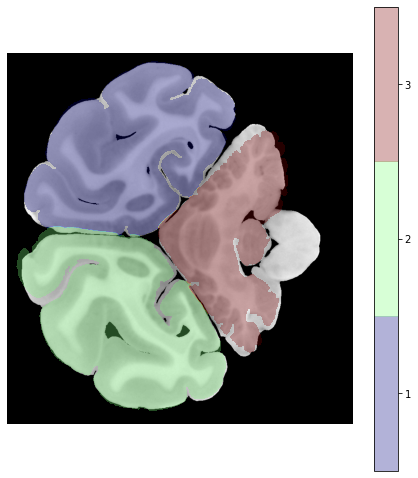

In [7]:
reference = bf_segments[0]
joint_mask = np.zeros_like(sitk.GetArrayViewFromImage(reference))

for i, t in enumerate(best_transforms):
    m = mask_segments[t.ntrans_ix]
    if t.flip:
        m = utils.flip_image(m)
    print(f"{i} \tmask {t.ntrans_ix} \tbf {t.bf_ix} \tflip {t.flip} \tmetric {t.metric}")
    out = sitk.GetArrayViewFromImage(reg.transform_image(m, t.transform, reference=reference, interpolator=sitk.sitkLinear)) > 0.5
    joint_mask[out] = i + 1

im.show(bf_gray, mask=joint_mask)